In [10]:
!pip install torch transformers==4.57.1 datasets peft trl accelerate safetensors pandas numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from trl import SFTTrainer
import torch

In [2]:
# Cell 2: Load and Explore Dataset
df = pd.read_csv("aapl_2022_cleaned_updated.csv")  # Or fetch via polygon as in tool
print(df.head())
print(df.info())

         Date  Close Price  High Price   Low Price  Open Price  Trading Volume
0  2022-01-03   178.645645  179.499574  174.425140  174.542917     104487900.0
1  2022-01-04   176.378311  179.558426  175.809030  179.254159      99310400.0
2  2022-01-05   171.686722  176.839679  171.411899  176.290033      94537600.0
3  2022-01-06   168.820679  172.059683  168.467333  169.507737      96904000.0
4  2022-01-07   168.987549  170.921136  167.868622  169.694241      86709100.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            251 non-null    object 
 1   Close Price     251 non-null    float64
 2   High Price      251 non-null    float64
 3   Low Price       251 non-null    float64
 4   Open Price      251 non-null    float64
 5   Trading Volume  251 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.9+ KB
None


In [3]:
# Cell 3: Prepare Custom Dataset for Fine-Tuning
# Format data as instruction-response pairs for causal LM fine-tuning
def format_example(row):
    prompt = f"Given the stock data for AAPL:\nOpen Price: {row['Open Price']}\nHigh Price: {row['High Price']}\nLow Price: {row['Low Price']}\nClose Price: {row['Close Price']}\nPredict the trading volume."
    response = f"The predicted trading volume is {row['Trading Volume']:.0f}."
    text = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n{response}<|im_end|>"
    return {"text": text}

# Apply formatting (use 80% for train, 20% for eval)
train_df = df.sample(frac=0.8, random_state=42)
eval_df = df.drop(train_df.index)

train_texts = [format_example(row) for _, row in train_df.iterrows()]
eval_texts = [format_example(row) for _, row in eval_df.iterrows()]

train_dataset = Dataset.from_list(train_texts)
eval_dataset = Dataset.from_list(eval_texts)

print(f"Training samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")
print("Sample text:", train_texts[0]["text"])

Training samples: 201, Eval samples: 50
Sample text: <|im_start|>user
Given the stock data for AAPL:
Open Price: 170.28801428832625
High Price: 171.20460883381332
Low Price: 169.1841727217911
Close Price: 170.53440856933594
Predict the trading volume.<|im_end|>
<|im_start|>assistant
The predicted trading volume is 56377100.<|im_end|>


In [7]:
# Cell 4: Load Model and Tokenizer without Quantization
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-0.5B-Instruct"  # Smallest variant for feasibility

# Load model without quantization for CPU compatibility
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float32,  # Use full precision for CPU
    device_map="cpu",  # Explicitly set to CPU
    trust_remote_code=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Confirm successful loading
print(f"Model loaded: {model_name}")
print(f"Model device: {model.device}")
print(f"Tokenizer loaded: {tokenizer.name_or_path}")
print(f"Pad token set to: {tokenizer.pad_token}")

Model loaded: Qwen/Qwen2.5-0.5B-Instruct
Model device: cpu
Tokenizer loaded: Qwen/Qwen2.5-0.5B-Instruct
Pad token set to: <|endoftext|>


In [8]:
# Cell 5: Configure LoRA for PEFT
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"]  # Adjust based on Qwen architecture
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093


In [2]:
from transformers import TrainingArguments

In [3]:
from transformers import TrainingArguments, AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from trl import SFTTrainer

In [5]:
import transformers
print(transformers.__version__)

4.56.1


In [6]:
pip install --upgrade transformers

   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.0 MB 419.4 kB/s eta 0:00:28
   - -------------------------------------- 0.5/12.0 MB 419.4 kB/s eta 0:00:28
   - -------------------------------------- 0.5/12.0 MB 419.4 kB/s eta 0:00:28
   -- ------------------------------------- 0.8/12.0 MB 404.2 kB/s eta 0:00:28
   -- ------------------------------------- 0.8/12.0 MB 404.2 kB/s eta 0:00:28
   -- ------------------------------------- 0.8/12.0 MB 404.2 kB/s eta 0:00:28
   --- ------------------------------------ 1.0/12.0 MB 419.4 kB/s eta 0:00:27
   --- --------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Cell 1: Imports
import pandas as pd
import numpy as np
from datasets import Dataset
from peft import LoraConfig, get_peft_model, TaskType
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,  # Added TrainingArguments
)
from trl import SFTTrainer
import torch

In [3]:
# Cell 2: Load and Explore Dataset
df = pd.read_csv("aapl_2022_cleaned_updated.csv")  # Ensure this file exists
print(df.head())
print(df.info())

         Date  Close Price  High Price   Low Price  Open Price  Trading Volume
0  2022-01-03   178.645645  179.499574  174.425140  174.542917     104487900.0
1  2022-01-04   176.378311  179.558426  175.809030  179.254159      99310400.0
2  2022-01-05   171.686722  176.839679  171.411899  176.290033      94537600.0
3  2022-01-06   168.820679  172.059683  168.467333  169.507737      96904000.0
4  2022-01-07   168.987549  170.921136  167.868622  169.694241      86709100.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            251 non-null    object 
 1   Close Price     251 non-null    float64
 2   High Price      251 non-null    float64
 3   Low Price       251 non-null    float64
 4   Open Price      251 non-null    float64
 5   Trading Volume  251 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.9+ KB
None


In [4]:
# Cell 3: Prepare Custom Dataset for Fine-Tuning
def format_example(row):
    prompt = f"Given the stock data for AAPL:\nOpen Price: {row['Open Price']}\nHigh Price: {row['High Price']}\nLow Price: {row['Low Price']}\nClose Price: {row['Close Price']}\nPredict the trading volume."
    response = f"The predicted trading volume is {row['Trading Volume']:.0f}."
    text = f"<|im_start|>user\n{prompt}<|im_end|>\n<|im_start|>assistant\n{response}<|im_end|>"
    return {"text": text}

train_df = df.sample(frac=0.8, random_state=42)
eval_df = df.drop(train_df.index)

train_texts = [format_example(row) for _, row in train_df.iterrows()]
eval_texts = [format_example(row) for _, row in eval_df.iterrows()]

train_dataset = Dataset.from_list(train_texts)
eval_dataset = Dataset.from_list(eval_texts)

print(f"Training samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")
print("Sample text:", train_texts[0]["text"])

Training samples: 201, Eval samples: 50
Sample text: <|im_start|>user
Given the stock data for AAPL:
Open Price: 170.28801428832625
High Price: 171.20460883381332
Low Price: 169.1841727217911
Close Price: 170.53440856933594
Predict the trading volume.<|im_end|>
<|im_start|>assistant
The predicted trading volume is 56377100.<|im_end|>


In [6]:
# Cell 4: Load Model and Tokenizer with Quantization
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Model loaded:", model is not None)

Model loaded: True


In [11]:
# Cell 5: Configure LoRA for PEFT
from peft import LoraConfig, get_peft_model, TaskType

# Ensure model is defined from Cell 4
if 'model' not in globals():
    raise NameError("Model not defined. Please run Cell 4 first.")

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,        #  for causal language modeling.
    inference_mode=False,                #   enables training mode.
    r=8,                                  #  LoRA rank, controlling the size of low-rank updates.
    lora_alpha=32,                         # Scaling factor for LoRA updates.
    lora_dropout=0.1,                     #  Dropout rate to prevent overfitting.
    target_modules=["q_proj", "v_proj"]  # Common target modules for Qwen architecture
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
print("LoRA model ready:", model is not None)
print("PEFT config defined:", peft_config is not None)

trainable params: 540,672 || all params: 494,573,440 || trainable%: 0.1093
LoRA model ready: True
PEFT config defined: True


In [19]:
# ✅ Cell 6: Training Setup and Execution (fixed + syntax error removed)

from transformers import TrainingArguments
from trl import SFTTrainer
import logging

logging.basicConfig(level=logging.INFO)

training_args = TrainingArguments(
    output_dir="./qwen_stock_predictor",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=10,
    logging_steps=10,
    save_steps=50,
    learning_rate=2e-4,
    fp16=False,
    remove_unused_columns=False,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    args=training_args,
)

print("\n🚀 Training started — please wait, this may take a few minutes...\n")

trainer.train()

trainer.save_model("./qwen_stock_predictor_final")
print("✅ Training complete! Model saved at './qwen_stock_predictor_final'")


Adding EOS to train dataset:   0%|          | 0/201 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/201 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/201 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.



🚀 Training started — please wait, this may take a few minutes...



C:\Users\Bhargavi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,2.406800
20,1.802200
30,1.442000


✅ Training complete! Model saved at './qwen_stock_predictor_final'


In [3]:
# Cell 7: Inference Example - Generate Prediction
import pandas as pd
from peft import PeftModel
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load dataset
try:
    df = pd.read_csv("aapl_2022_cleaned_updated.csv")
    train_df = df.sample(frac=0.8, random_state=42)
    eval_df = df.drop(train_df.index)
    print(df.head())
    print(df.info())
except FileNotFoundError:
    print("❌ Error: aapl_2022_cleaned_updated.csv not found. Please ensure the file is in the working directory.")
    raise

# Define model name and device
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for inference: {device}")

# Load fine-tuned model without quantization (consistent with Cell 4)
try:
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype=torch.float32,
        device_map="cpu",
        trust_remote_code=True,
        low_cpu_mem_usage=True
    )
    
    model = PeftModel.from_pretrained(base_model, "./qwen_stock_predictor_final")
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

    # Set pad token if missing
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    model = model.to(device)
    model.eval()

    # Select a sample from eval_df for inference
    row = eval_df.iloc[0]
    prompt = f"""<|im_start|>user
Given the stock data for AAPL:
Open Price: {row['Open Price']}
High Price: {row['High Price']}
Low Price: {row['Low Price']}
Close Price: {row['Close Price']}
Predict the trading volume.
Respond with only a numeric value (no words).
<|im_end>
<|im_start>assistant
"""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    print(f"\n🟢 Model prediction for trading volume: {response}")
    print(f"Actual trading volume: {row['Trading Volume']:.0f}")

except Exception as e:
    print(f"❌ Error during model loading or inference: {e}")

         Date  Close Price  High Price   Low Price  Open Price  Trading Volume
0  2022-01-03   178.645645  179.499574  174.425140  174.542917     104487900.0
1  2022-01-04   176.378311  179.558426  175.809030  179.254159      99310400.0
2  2022-01-05   171.686722  176.839679  171.411899  176.290033      94537600.0
3  2022-01-06   168.820679  172.059683  168.467333  169.507737      96904000.0
4  2022-01-07   168.987549  170.921136  167.868622  169.694241      86709100.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            251 non-null    object 
 1   Close Price     251 non-null    float64
 2   High Price      251 non-null    float64
 3   Low Price       251 non-null    float64
 4   Open Price      251 non-null    float64
 5   Trading Volume  251 non-null    float64
dtypes: float64(5), object(1)
memory usage: 11.9+ KB
None
Usin

In [5]:
# Cell 8: Evaluation (MSE, MAE on generated vs actual)
import pandas as pd
import re
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load dataset and create eval_df
try:
    df = pd.read_csv("aapl_2022_cleaned_updated.csv")
    train_df = df.sample(frac=0.8, random_state=42)
    eval_df = df.drop(train_df.index)
    print(f"Evaluation samples: {len(eval_df)}")
except FileNotFoundError:
    print("Error: aapl_2022_cleaned_updated.csv not found. Please ensure the file is in the working directory.")
    raise

# Define model name and device
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for inference: {device}")

# Load fine-tuned model without quantization (consistent with Cell 4)
try:
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype=torch.float32,
        device_map="cpu",
        trust_remote_code=True,
        low_cpu_mem_usage=True,
    )
    model = PeftModel.from_pretrained(base_model, "./qwen_stock_predictor_final")
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
except Exception as e:
    print(f"Error loading fine-tuned model: {e}")
    raise

def extract_volume(text):
    match = re.search(r'(\d+(?:\.\d+)?)', text)
    return float(match.group(1)) if match else None

predictions = []
actuals = []

for _, row in eval_df.iterrows():
    prompt = f"""<|im_start|>user
Given the stock data for AAPL:
Open Price: {row['Open Price']}
High Price: {row['High Price']}
Low Price: {row['Low Price']}
Close Price: {row['Close Price']}
Predict the trading volume.
Respond with only a numeric value (no words).
<|im_end>
<|im_start>assistant
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    
    pred_vol = extract_volume(generated)
    if pred_vol is not None and 0 < pred_vol < 1e10:  # Prevent extreme outliers
        predictions.append(pred_vol)
        actuals.append(row["Trading Volume"])

if predictions:
    mse = np.mean([(p - a) ** 2 for p, a in zip(predictions, actuals)])
    mae = np.mean([abs(p - a) for p, a in zip(predictions, actuals)])
    print(f"Mean Squared Error on eval set: {mse:.2f}")
    print(f"Mean Absolute Error on eval set: {mae:.2f}")
    print(f"Sample predictions: {predictions[:5]}")
    print(f"Sample actuals: {actuals[:5]}")
else:
    print("No valid predictions extracted.")

Evaluation samples: 50
Using device for inference: cpu
Mean Squared Error on eval set: 8444450928302868.00
Mean Absolute Error on eval set: 88782218.70
Sample predictions: [179.25415901450634, 157.06212195335075, 170.79353091508946, 171.51984280427115, 161.0163992959612]
Sample actuals: [99310400.0, 162294600.0, 86213900.0, 84914300.0, 91974200.0]


Evaluation samples: 50
Using device for inference: cpu
Mean Squared Error on eval set: 8444450928302868.00
Mean Absolute Error on eval set: 88782218.70
Sample predictions: [179.25415901450634, 157.06212195335075, 170.79353091508946, 171.51984280427115, 161.0163992959612]
Sample actuals: [99310400.0, 162294600.0, 86213900.0, 84914300.0, 91974200.0]


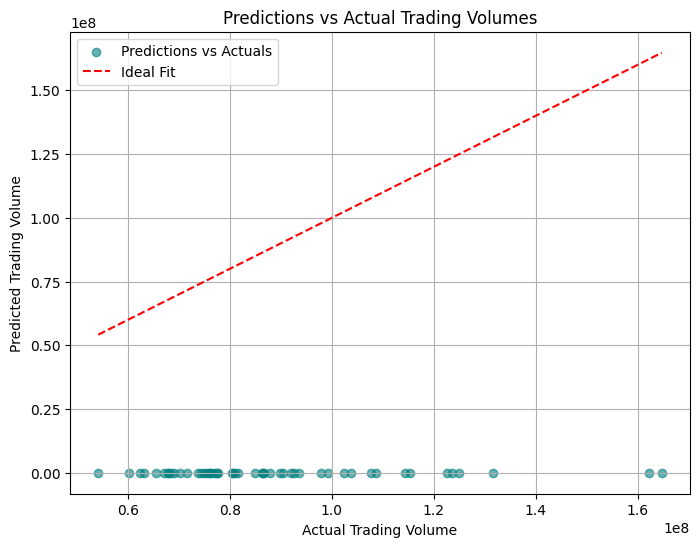

In [6]:
# Cell 8: Evaluation (MSE, MAE, and Matplotlib Visualization)
import pandas as pd
import re
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# Load dataset and create eval_df
try:
    df = pd.read_csv("aapl_2022_cleaned_updated.csv")
    train_df = df.sample(frac=0.8, random_state=42)
    eval_df = df.drop(train_df.index)
    print(f"Evaluation samples: {len(eval_df)}")
except FileNotFoundError:
    print("Error: aapl_2022_cleaned_updated.csv not found. Please ensure the file is in the working directory.")
    raise

# Define model name and device
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device for inference: {device}")

# Load fine-tuned model without quantization (consistent with Cell 4)
try:
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        dtype=torch.float32,
        device_map="cpu",
        trust_remote_code=True,
        low_cpu_mem_usage=True,
    )
    model = PeftModel.from_pretrained(base_model, "./qwen_stock_predictor_final")
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
except Exception as e:
    print(f"Error loading fine-tuned model: {e}")
    raise

def extract_volume(text):
    match = re.search(r'(\d+(?:\.\d+)?)', text)
    return float(match.group(1)) if match else None

predictions = []
actuals = []

for _, row in eval_df.iterrows():
    prompt = f"""<|im_start|>user
Given the stock data for AAPL:
Open Price: {row['Open Price']}
High Price: {row['High Price']}
Low Price: {row['Low Price']}
Close Price: {row['Close Price']}
Predict the trading volume.
Respond with only a numeric value (no words).
<|im_end>
<|im_start>assistant
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            temperature=0.7,
            top_p=0.9,
            do_sample=True
        )
    generated = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    
    pred_vol = extract_volume(generated)
    if pred_vol is not None and 0 < pred_vol < 1e10:  # Prevent extreme outliers
        predictions.append(pred_vol)
        actuals.append(row["Trading Volume"])

if predictions:
    mse = np.mean([(p - a) ** 2 for p, a in zip(predictions, actuals)])
    mae = np.mean([abs(p - a) for p, a in zip(predictions, actuals)])
    print(f"Mean Squared Error on eval set: {mse:.2f}")
    print(f"Mean Absolute Error on eval set: {mae:.2f}")
    print(f"Sample predictions: {predictions[:5]}")
    print(f"Sample actuals: {actuals[:5]}")
    
    # Visualize predictions vs actuals with Matplotlib
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, color='teal', alpha=0.6, label='Predictions vs Actuals')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Trading Volume')
    plt.ylabel('Predicted Trading Volume')
    plt.title('Predictions vs Actual Trading Volumes')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid predictions extracted.")